In [1]:
filepath = 'data/'
#Imports
import pandas as pd
import numpy as np
from category_encoders import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import RandomizedSearchCV

def wrangle(fm_path, tv_path=None):
    if tv_path:
        df = pd.merge(pd.read_csv(fm_path),
                      pd.read_csv(tv_path)).set_index('building_id')
    else:
        df = pd.read_csv(fm_path, index_col='building_id')
        
    
    return df

In [2]:
df = wrangle(filepath + 'train_values.csv', filepath + 'train_labels.csv')
print(df.shape)
df.head()

(260601, 39)


,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
building_id,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,3
28830,8,900,2812,2,10,8,7,o,r,n,...,0,0,0,0,0,0,0,0,0,2
94947,21,363,8973,2,10,5,5,t,r,n,...,0,0,0,0,0,0,0,0,0,3
590882,22,418,10694,2,10,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,2
201944,11,131,1488,3,30,8,9,t,r,n,...,0,0,0,0,0,0,0,0,0,3


In [3]:
target = 'damage_grade'
X = df.drop(columns=target)
y = df[target]
print(X.shape)
y.shape

(260601, 38)


(260601,)

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
print('Baseline accuracy:', y_train.value_counts(normalize=True).max())

Baseline accuracy: 0.5697045280122793


In [6]:
model_xgb = make_pipeline(
            OrdinalEncoder(),
            XGBClassifier(random_state=42, n_jobs=-1)
)
model_xgb.fit(X_train, y_train)

C:\Users\Daos\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:45:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['land_surface_condition',
                                      'foundation_type', 'roof_type',
                                      'ground_floor_type', 'other_floor_type',
                                      'position', 'plan_configuration',
                                      'legal_ownership_status'],
                                mapping=[{'col': 'land_surface_condition',
                                          'data_type': dtype('O'),
                                          'mapping': n      1
o      2
t      3
NaN   -2
dtype: int64},
                                         {'col': 'foundation_type',
                                          'data_type': dtype('O...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, 

In [7]:
print('XGB initial train score: ', model_xgb.score(X_train, y_train))
print('XGB initial validation score: ', model_xgb.score(X_val, y_val))

XGB initial train score:  0.7479374520337683
XGB initial validation score:  0.7270965637650851


In [8]:
#This is significantly lower than the best model the RandomForestClassifier gives us, so let's try to tune it.
#start with parameter importance:
perm_imp = permutation_importance(model_xgb, X_val, y_val, random_state=42)
data = {'imp_mean':perm_imp['importances_mean'],
        'imp_std':perm_imp['importances_std']}
df_perm = pd.DataFrame(data, index=X_val.columns).sort_values('imp_mean')
df_perm

,imp_mean,imp_std
has_secondary_use_industry,-0.000042,0.000022
has_secondary_use_health_post,-0.000004,0.000022
has_secondary_use_gov_office,0.000000,0.000000
has_secondary_use_use_police,0.000000,0.000000
has_secondary_use_institution,0.000008,0.000026
has_secondary_use_hotel,0.000023,0.000086
has_secondary_use_school,0.000042,0.000014
has_secondary_use_other,0.000115,0.000044
has_secondary_use_rental,0.000165,0.000081
has_superstructure_rc_non_engineered,0.000230,0.000111


In [9]:
#Let's take everything with less than or equal to 0 imp_mean out:
cols_to_remove = df_perm[df_perm['imp_mean'] <= 0].index
model_xgb_ct = make_pipeline(
            OrdinalEncoder(),
            XGBClassifier(random_state=42, n_jobs=-1)
)
model_xgb_ct.fit(X_train.drop(columns=cols_to_remove), y_train)

C:\Users\Daos\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:46:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['land_surface_condition',
                                      'foundation_type', 'roof_type',
                                      'ground_floor_type', 'other_floor_type',
                                      'position', 'plan_configuration',
                                      'legal_ownership_status'],
                                mapping=[{'col': 'land_surface_condition',
                                          'data_type': dtype('O'),
                                          'mapping': n      1
o      2
t      3
NaN   -2
dtype: int64},
                                         {'col': 'foundation_type',
                                          'data_type': dtype('O...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, 

In [10]:
print('XGB columns removed train score: ', model_xgb_ct.score(X_train.drop(columns=cols_to_remove), y_train))
print('XGB columns removed validation score: ', model_xgb_ct.score(X_val.drop(columns=cols_to_remove), y_val))

XGB columns removed train score:  0.7480285878741366
XGB columns removed validation score:  0.7275570307553577


In [11]:
#the model did improve, if only slightly, from the removal of these columns. 
#Let's keep them out and do some hyperparameter tuning
clf = make_pipeline(
            OrdinalEncoder(),
            XGBClassifier(random_state=42, n_jobs=-1)
)
params_grid = {
    'xgbclassifier__learning_rate':np.arange(0.1, 1.0, 0.1),
    'xgbclassifier__n_estimators':range(50, 150, 10)
}

model = RandomizedSearchCV(
    clf, 
    param_distributions=params_grid,
    n_jobs=-1,
    n_iter=30,
    cv=5,
    verbose=1
    )
model.fit(X.drop(columns=cols_to_remove), y)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


C:\Users\Daos\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:27:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder()),
                                             ('xgbclassifier',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            gamma=None,
                                                            gpu_id=None,
                                                            importance_type='gain',
                                                            interaction_constraints=None,
                                                            lea

In [12]:
model_be = model.best_estimator_
print('XGB hyperparameter tuned train score: ', model_be.score(X_train.drop(columns=cols_to_remove), y_train))
print('XGB hyperparameter tuned validation score: ', model_be.score(X_val.drop(columns=cols_to_remove), y_val))
model.best_params_

XGB hyperparameter tuned train score:  0.7876103223330775
XGB hyperparameter tuned validation score:  0.7848467987951113


{'xgbclassifier__n_estimators': 140, 'xgbclassifier__learning_rate': 0.8}

In [13]:
#There was a significant improvement on the model with the tuned hyperparams, let's keep model_be and get the shap description:
#first we have to encode the data:
from sklearn.preprocessing import LabelEncoder
cols_to_encode = X.select_dtypes(include='object').columns
X_c = X.copy()
le = LabelEncoder()
for col in cols_to_encode:
    X_c[col] = le.fit_transform(X_c[col])

X_c_train = X_c.loc[X_train.index]
X_c_val = X_c.loc[X_val.index]

In [14]:
#re-fit model:
model_np = XGBClassifier(n_estimators=130, learning_rate=0.7, random_state=42, n_jobs=-1)
model_np.fit(X_c_train, y_train)

C:\Users\Daos\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:28:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.7, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=130, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [15]:
#install and import shap:
!pip install shap
import shap

In [16]:
#Shap explainer:
explainer = shap.Explainer(model_np)
shap_values = explainer(X_c_val)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


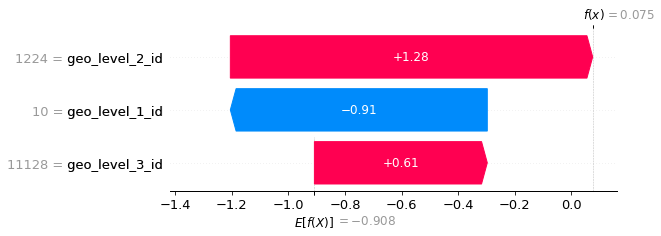

In [17]:
#Shap waterfall:
row = 0
shap.waterfall_plot(shap.Explanation(values=shap_values[0][row].base_values, 
                                     base_values=explainer.expected_value[0],
                                     data=X_c_val.iloc[row],  
                                     feature_names=X_c_val.columns.tolist()))
